# Détection des panneaux sur des images ou un flux vidéo

Détection et reconnaissance de la signalisation routière, notebook 2/2

<hr>

- <a href='#1'>1. Prise en main du modèle entrainé avec Tensorflow API Detection</a>
- <a href='#2'>2. Détection et reconnaissance des panneaux dans une image</a>
- <a href='#3'>3. Détection et reconnaissance des panneaux dans une vidéo</a>

<hr>

In [1]:
import cv2
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [2]:
LABELS = { 0:'Vitesse limite 20km h',
            1:'Vitesse limite 30km h', 
            2:'Vitesse limite 50km h', 
            3:'Vitesse limite 60km h', 
            4:'Vitesse limite 70km h', 
            5:'Vitesse limite 80km h', 
            6:'Fin de limite de vitesse 80kmh', 
            7:'Vitesse limite 100km h', 
            8:'Vitesse limite 120km h', 
            9:'Depassement interdit sauf 2 roues', 
            10:'Dépassement interdit pour plus de 3.5t', 
            11:'Priorite a droite a l intersection', 
            12:'Route prioritaire', 
            13:'Cedez le passage', 
            14:'Stop', 
            15:'Interdit aux vehicules', 
            16:'Vehicules de plus de 3.5t interdits', 
            17:'Sens interdit', 
            18:'Panneau danger', 
            19:'Virage dangereux a gauche', 
            20:'Virage dangereux a droite', 
            21:'Succession de virages', 
            22:'Cassis ou dos d anes', 
            23:'Route glissante', 
            24:'Chaussee retrecie par la droite', 
            25:'Travaux', 
            26:'Feux tricolore', 
            27:'Passage pieton', 
            28:'Attention enfants', 
            29:'Attention velos', 
            30:'Attention neige verglas',
            31:'Passage animaux sauvages', 
            32:'Fin de toutes interdictions', 
            33:'Direction obligatoire a droite', 
            34:'Direction obligatoire a gauche', 
            35:'Direction obligatoire tout droit', 
            36:'Direction obligatoire tout droit ou a droite', 
            37:'Direction obligatoire tout droit ou gauche', 
            38:'Contournement obligatoire par la droite', 
            39:'Contournement obligatoire par la gauche', 
            40:'Giratoire', 
            41:'Fin de l interdiction de depassement', 
            42:'Fin de l interdiction de depassement plus de 3.5t' }

## <a id='1'>1. Prise en main du modèle entrainé avec Tensorflow API Detection</a>

Ici on découvre le fonctionnement du modèle obtenu avec Tensorflow, qui est différents de ceux qu'on avait l'habiture d'utiliser avec Keras. 

Pour les résultats, passer directement à la section 2.

In [71]:
## on charge quelques images pour les tests
image1 = cv2.imread("images/signates3.jpg")
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

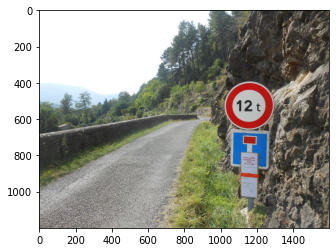

In [72]:
plt.imshow(image1)

In [73]:
# chargement des modèles
model_rec = tf.keras.models.load_model('model_recog_93')
model_loc = tf.saved_model.load('model_loc') # se charge différemment d'un modèle Keras !

On peut visualiser les infos du modèle sauvegardé avec la commande bash suivante :
```bash
saved_model_cli show --dir PATH/TO/saved_model --tag_set serve --signature_def serving_default
```

Cette commande nous renvoie l'input attendue ar le modèle, ainsi que les clés utilisables pourobtenir les résultats du processing par le modèle.

In [75]:
!saved_model_cli show --dir C:/Tensorflow/models/research/object_detection/EXPORTED_MODEL/inference_graph/saved_model \
    --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['input_tensor'] tensor_info:
      dtype: DT_UINT8
      shape: (1, -1, -1, 3)
      name: serving_default_input_tensor:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['detection_anchor_indices'] tensor_info:
      dtype: DT_FLOAT
      shape: (1, 300)
      name: StatefulPartitionedCall:0
  outputs['detection_boxes'] tensor_info:
      dtype: DT_FLOAT
      shape: (1, 300, 4)
      name: StatefulPartitionedCall:1
  outputs['detection_classes'] tensor_info:
      dtype: DT_FLOAT
      shape: (1, 300)
      name: StatefulPartitionedCall:2
  outputs['detection_multiclass_scores'] tensor_info:
      dtype: DT_FLOAT
      shape: (1, 300, 2)
      name: StatefulPartitionedCall:3
  outputs['detection_scores'] tensor_info:
      dtype: DT_FLOAT
      shape: (1, 300)
      name: StatefulPartitionedCall:4
  outputs['num_detections'] tensor_info:
      dtype: DT_FLOAT
      shape: (1)
    

2021-03-08 20:56:47.844844: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-03-08 20:56:47.844891: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


On voit que le modèle demande un _tenseur_ en entrée, de la forme (1, -1, -1, 3), c'est à dire par batch de 1, longueur et largeur non imposées, couleur.
```bash
  inputs['input_tensor'] tensor_info:
      dtype: DT_UINT8
      shape: (1, -1, -1, 3)
```

In [127]:
image = image1
print(image.shape, type(image))

(1200, 1600, 3) <class 'numpy.ndarray'>


Or notre image est un array numpy de 3 dimensions, on doit donc transformer la transformer en tenseur et ajouter un axe pour le batch.

In [128]:
input_tensor = tf.convert_to_tensor(image) # conversion en tenseur
input_tensor = input_tensor[tf.newaxis,...]

In [129]:
input_tensor

<tf.Tensor: shape=(1, 1200, 1600, 3), dtype=uint8, numpy=
array([[[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [ 85,  79,  67],
         [105,  98,  88],
         [109, 102,  92]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [130, 124, 110],
         [134, 128, 116],
         [115, 109,  97]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [131, 124, 108],
         [122, 115,  99],
         [121, 114,  98]],

        ...,

        [[111,  90,  85],
         [155, 136, 130],
         [140, 123, 115],
         ...,
         [122, 123, 115],
         [100, 101,  95],
         [ 95,  96,  88]],

        [[130, 107, 101],
         [130, 110, 103],
         [142, 123, 116],
         ...,
         [107, 110, 103],
         [ 97,  99,  94],
         [101, 104,  97]],

        [[182, 159, 153],
         [137, 117, 110],
         [182, 1

In [130]:
# la fonction qui sert à la prédiction se  trouve dans le module "signature" du modèle
model_loc.signatures

_SignatureMap({'serving_default': <ConcreteFunction signature_wrapper(*, input_tensor) at 0x1FAC23C6908>})

In [131]:
model_locX = model_loc.signatures['serving_default']
output_dict = model_locX(input_tensor)
output_dict.keys()

dict_keys(['num_detections', 'detection_anchor_indices', 'detection_multiclass_scores', 'detection_scores', 'raw_detection_scores', 'raw_detection_boxes', 'detection_classes', 'detection_boxes'])

In [132]:
num_detections = int(output_dict.pop('num_detections'))
output_dict = {key:value[0, :num_detections].numpy() 
             for key,value in output_dict.items()}
output_dict['num_detections'] = num_detections

output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)

In [133]:
boxes = output_dict['detection_boxes']
scores = output_dict['detection_scores']
scores = np.array(scores)

In [134]:
real_boxes = boxes[np.where(scores > 0.5)]
real_boxes

array([[0.33915207, 0.6379132 , 0.5572445 , 0.8104059 ]], dtype=float32)

In [135]:
image.shape

(1200, 1600, 3)

In [136]:
real_boxes_scaled =[]
for box in real_boxes :
    x1 = int(image.shape[1]*box[1])
    x2 = int(image.shape[1]*box[3])
    y1 = int(image.shape[0]*box[0])
    y2 = int(image.shape[0]*box[2])
    real_boxes_scaled.append((x1, x2, y1, y2))

In [137]:
real_boxes_scaled

[(1020, 1296, 406, 668)]

In [138]:
for box in real_boxes_scaled :
    (x1, x2, y1, y2) = box
    image = cv2.rectangle(image, (x1, y1), (x2, y2), (255, 255, 0), 4)

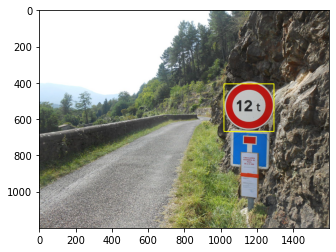

In [139]:
plt.imshow(image)

## <a id='2'>2. Détection et reconnaissance des panneaux dans une image</a>

In [140]:
model_rec = tf.keras.models.load_model('model_recog_96')
model_loc = tf.saved_model.load('model_loc') 
model_locX = model_loc.signatures['serving_default']

In [155]:
# création de la fonction de détection et classification des panneaux
def detect_and_classify_roadsign(file):
    image = cv2.imread(file, 3)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    input_tensor = tf.convert_to_tensor(image) # conversion en tenseur
    input_tensor = input_tensor[tf.newaxis,...]
    output_dict = model_locX(input_tensor)
    
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() for key,value in output_dict.items()}
    
    scores = np.array(output_dict['detection_scores'])
    
    boxes = output_dict['detection_boxes']
    real_boxes = boxes[np.where(scores > 0.5)]
    
    real_boxes_scaled =[]
    localized =[]
    for box in real_boxes :
        x1 = int(image.shape[1]*box[1])
        x2 = int(image.shape[1]*box[3])
        y1 = int(image.shape[0]*box[0])
        y2 = int(image.shape[0]*box[2])
        
        cropped = image[y1:y2, x1:x2]
        gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
        resized = (cv2.resize(gray,(50,50)).astype('float') / 255).reshape(1,50,50,1)
        
        localized.append(resized)
        real_boxes_scaled.append([x1, x2, y1, y2])
        
    recognized=[]
    for i in range(len(localized)) : # pour chaque couple (bbox, panneau)
        recognized = np.argmax(model_rec.predict(localized[i])) # reconaissance du panneau
        x1, x2, y1, y2 = real_boxes_scaled[i] # récupération des coordonnées de la bbox pour tracer le rectangle
        image = cv2.rectangle(image, (x1, y1), (x2, y2), (255, 255, 0), 5) # on trace le rectangle
        image = cv2.putText(image, LABELS[recognized], (x1-22, y1-16), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,0), 2)
    plt.figure(figsize=(12, 7))
    plt.axis("off")
    plt.imshow(image)

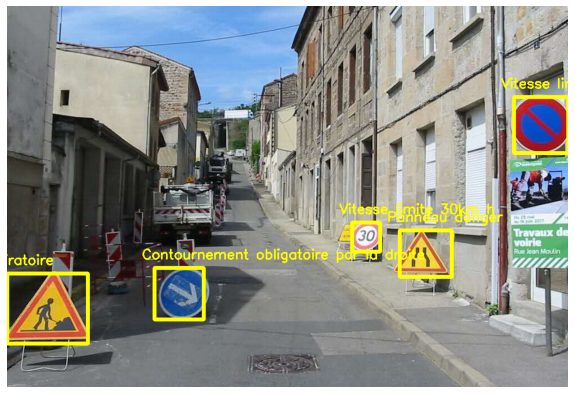

In [156]:
#test
detect_and_classify_roadsign("images/signates4.jpg")

## <a id='3'>3. Détection et reconnaissance des panneaux dans une vidéo</a>

In [143]:
model_rec = tf.keras.models.load_model('model_recog_96')
model_loc = tf.saved_model.load('model_loc') 
model_locX = model_loc.signatures['serving_default']

In [157]:
def detect_and_classify_roadsign_video(frame):
    input_tensor = tf.convert_to_tensor(frame) # conversion en tenseur
    input_tensor = input_tensor[tf.newaxis,...]
    output_dict = model_locX(input_tensor)
    
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() for key,value in output_dict.items()}
    
    scores = np.array(output_dict['detection_scores'])
    
    boxes = output_dict['detection_boxes']
    real_boxes = boxes[np.where(scores > 0.5)]
    
    real_boxes_scaled =[]
    localized =[]
    for box in real_boxes :
        x1 = int(frame.shape[1]*box[1])
        x2 = int(frame.shape[1]*box[3])
        y1 = int(frame.shape[0]*box[0])
        y2 = int(frame.shape[0]*box[2])
        
        cropped = frame[y1:y2, x1:x2]
        gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
        resized = (cv2.resize(gray,(50,50)).astype('float') / 255).reshape(1,50,50,1)
        
        localized.append(resized)
        real_boxes_scaled.append([x1, x2, y1, y2])
        
    recognized=[]
    for i in range(len(localized)) :
        recognized = np.argmax(model_rec.predict(localized[i])) # reconaissance du panneau
        x1, x2, y1, y2 = real_boxes_scaled[i] # récupération des coordonnées de la bbox pour tracer le rectangle
        frame = cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 255, 0), 3) # on trace le rectangle
        frame = cv2.putText(frame, LABELS[recognized], (x1-22, y1-16), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,0), 2)

    return frame

In [158]:
def process_video(file, record_name=None): #copyright Pereg pour l'enregistrement qui a du style et de la classe
    cap = cv2.VideoCapture(file)

    if (cap.isOpened()== False): 
        print("Error opening video stream or file")
    else :
        # get vcap property
        global_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        global_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    if record_name:
        result = cv2.VideoWriter(record_name,  cv2.VideoWriter_fourcc(*'MJPG'), 15, (global_width, global_height)) 
        
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:

            frame_processed = detect_and_classify_roadsign_video(frame)

            cv2.imshow('Frame',frame)

            if cv2.waitKey(1) == 27:
                break

        else: 
            break

    cap.release()
    if record_name:
        result.release()
    cv2.destroyAllWindows()

In [159]:
process_video("./vid.mp4", 'output1.avi')